<h1>Team Carbon: Final Project</h1>

By: Pierce Fleming
Class: (CPSC 310, Spring 2019) at Gonzaga University
Description: Using diamond attribute dataset to classify diamonds by price  
Will be using: kNN, tensorflow estimator, tdidt, and kNN ensemble

Sources to cite: https://www.tensorflow.org/guide/datasets_for_estimators, https://nbviewer.jupyter.org/gist/yufengg/a6dff912ab48f7a273f5704ad9ab1311

# Introduction

### The Dataset
Dataset contains data from 53,941 diamonds, with 9 different attributes

I decided to make 3 different classifiers to classify on price

The classifiers I chose were: kNN, kNN ensemble, TDIDT, and tensorflow linear evaluator

Out of these classifiers, the standalone kNN classifier had the best overall performance

# Data Analysis:
### a. The Dataset
Dataset contains data from 53,941 diamonds  

Attributes:  
Index counter: Index of current record  
carat: weight of the diamond (0.2--5.01)  
cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)  
color: diamond color, from J (worst) to D (best)  
clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))  
depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)  
table: width of top of diamond relative to widest point (43--95)  
price: price in US dollars (\$326--\$18,823)  
x: length in mm (0--10.74)  
y: width in mm (0--58.9)  
z: depth in mm (0--31.8)

Price (1-10) was used for the label after discretizes with 10 equal length bins



## Cleaning the Data

I cut dataset down to 2k records to reduce runtime.
I discretized price using 10 equal width bins, with values ranging from 1 to 10.  
For kNN, I made categorical values (cut, color, quality) into continuous values.

In [1]:
# Clean data
def clean_data():
    diamonds_table_normal = []
    
    # reading csv into table
    diamonds_table_normal = utils.read_csv("diamonds.csv")
    
    # splits dataset into desired sample size to reduce operation runtimes (original dataset has > 50k records)
    diamonds_table_normal = split_dataset(diamonds_table_normal, 2000)
    
    # removes "record" attributes
    diamonds_table_normal = utils.remove_record(diamonds_table_normal) # removes the "record" column from the dataset
    
    # prints summary stats
    print("Summary Stats For Diamond Dataset: ")
    utils.get_summary_stats(diamonds_table_normal)
    utils.write_table("diamonds_table_normal.csv", diamonds_table_normal)
    
    # equal length bins for classification
    diamonds_table_normal = utils.discretization(diamonds_table_normal, 6, 10) # discretizes price column on 1-10 scale
    
    return diamonds_table_normal

In [2]:
# splits dataset into desired sample size. This is to reduce the runtime of certain operation, such as normalization
def split_dataset(table, sample_size):
    table_sample = []
    
    n = len(table)
    for i in range(sample_size):
        j = random.randrange(0, n)
        table_sample.append(table[j])
    
    return table_sample

In [3]:
def compute_holdout_partitions(table):
    # randomize the table
    training_set = []
    testing_set = []
    training_set_original = []
    testing_set_original = []
    original_table = []

    randomized = table[:]  # copy the table
    n = len(table)
    for i in range(n):
        # pick an index to swap
        j = random.randrange(0, n)  # random int in [0,n)
        randomized[i], randomized[j] = randomized[j], randomized[i]
    # return train and test sets
    # 2/3 of randomized table is train, 1/3 is test
    split_index = int((2.0/3.0) * n)
    # original_table = randomized[:]
    original_table = copy.deepcopy(randomized)  # DEEP copy
    randomized = utils.normalize_table(randomized)

    training_set, testing_set = randomized[0:
                                           split_index], randomized[split_index:]
    training_set_original, testing_set_original = original_table[
        0:split_index], original_table[split_index:]

    return training_set, testing_set, training_set_original, testing_set_original

### b. Summary Statistics

SUMMARY STATISTICS:  
│ attribute: carat │
│ mean: 0.79       │
│ std: 0.47        │

│ attribute: depth │
│ mean: 61.8       │
│ std: 1.47        │

│ attribute: table │
│ mean: 57.48      │
│ std: 2.2         │

│ attribute: price │
│ mean: 3818.6     │
│ std: 3863.79     │

│ attribute: x_length │
│ mean: 5.71          │
│ std: 1.13           │

│ attribute: y_width │
│ mean: 5.72         │
│ std: 1.12          │

### c. Visualizations
The only visualizations that really stood out were the carat and price frequency diagrams, when compared side by side

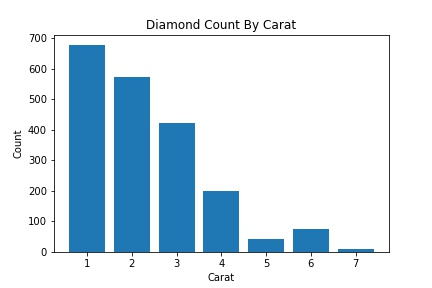

In [4]:
# Figure 1: Shows a frequency diagram for Diamond Count by Carat
from IPython.display import Image
Image(filename='carat_freq_diagram.jpg')

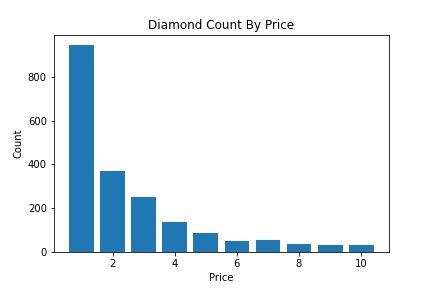

In [5]:
# Figure 2: Shows a frequency diagram for Diamond Count by Price
from IPython.display import Image
Image(filename='price_freq_diagram.jpg')

### Correlation
When I saw the correlation, I knew I should do a linear regression. After doing so, it's clear that carat is closely tied to price and vice versa

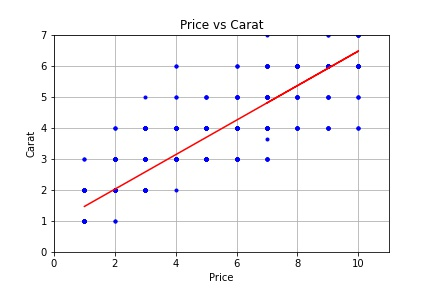

In [6]:
# Figure 3: Shows a Linear Regression for Price vs Carat 
from IPython.display import Image
Image(filename='price_carat_lin_regression.jpg')

In [7]:
def linear_regression_plot(one, two, filename, label1, label2):
    # reset figure
    x = np.array(one)
    y = np.array(two)

    xs = x
    ys = y
    # mpg always y-axis
    plt.figure()

    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(label1 + " vs " + label2)
    # create the scatter plot
    plt.plot(xs, ys, "b.")

    # make axis a bit longer and wider
    plt.xlim(0, int(max(xs) * 1.10))
    plt.ylim(0, int(max(ys) * 1.10))
    plt.grid(True)

    # plt.savefig(filename)
    # r = correlation coefficient
    # covariance
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)
    covar = np.cov(xs, ys)
    line = slope*xs+intercept
    plt.plot(xs, line, 'r')
    plt.text(350, 45, ["corr: " + str(round(r_value,2)), "cov: " + str(round(covar[1][0],2))], fontsize='8', bbox=dict(facecolor='red', alpha=0.5))

    plt.savefig(filename)
    plt.show()

In [8]:
def scatter_plot(one, two, filename, label):
    # reset figure
    x = np.array(one)
    y = np.array(two)

    xs = x
    ys = y
    # mpg always y-axis
    plt.figure()

    plt.xlabel(label)
    plt.ylabel("price")
    plt.title(label + " vs " + "Price")
    # create the scatter plot
    plt.plot(xs, ys, "b.")

    # make axis a bit longer and wider
    plt.xlim(0, int(max(xs) * 1.10))
    plt.ylim(0, int(max(ys) * 1.10))
    plt.grid(True)

    plt.savefig(filename)

In [9]:
def perform_vizualizations(table):
    table2 = copy.deepcopy(table)
    att_list = []
    att_count = []
    price_list = []
    carat_list = []
    
    
#     carat_list = read_attribute(table2, 0)
#     price_list = read_attribute(table2, 6)
    # Carat, cut, color, clarity, depth, table, price, x_length, y_width, z_depth
    
    table2 = utils.discretization(table2, 0, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 0)
#     carat_list = copy.deepcopy(att_list)
    frequency_diagram(att_list, att_count, "carat_freq_diagram.jpg", "Carat")
    
    table2 = utils.discretization(table2, 4, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 4)
    frequency_diagram(att_list, att_count, "depth_freq_diagram.jpg", "Depth")
    
    table2 = utils.discretization(table2, 5, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 5)
    frequency_diagram(att_list, att_count, "table_freq_diagram.jpg", "Table")
    
    table2 = utils.discretization(table2, 6, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 6)
    price_list = copy.deepcopy(att_list)
    frequency_diagram(att_list, att_count, "price_freq_diagram.jpg", "Price")
    
    table2 = utils.discretization(table2, 7, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 7)
    frequency_diagram(att_list, att_count, "x_length_freq_diagram.jpg", "X_Length")
    
    table2 = utils.discretization(table2, 8, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 8)
    frequency_diagram(att_list, att_count, "y_length_freq_diagram.jpg", "Y_Length")
    
    table2 = utils.discretization(table2, 9, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 9)
    frequency_diagram(att_list, att_count, "z_length_freq_diagram.jpg", "Z_Depth")
    
#     table2 = make_continuous(table)

    
    #     table2 = discretization(table2, 1, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 1)
    frequency_diagram(att_list, att_count, "cut_freq_diagram.jpg", "Cut")
    
#     table2 = discretization(table2, 2, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 2)
    frequency_diagram(att_list, att_count, "color_freq_diagram.jpg", "Color")
    
#     table2 = discretization(table2, 3, 10)
    att_list, att_count = utils.get_frequencies_string(table2, 3)
    frequency_diagram(att_list, att_count, "clarity_freq_diagram.jpg", "Clarity")
    
    carat_list = utils.read_attribute(table2, 0)
    price_list = utils.read_attribute(table2, 6)
#     print(price_list)
    linear_regression_plot(price_list, carat_list, "price_carat_lin_regression.jpg", "Price", "Carat")
    scatter_plot(price_list, carat_list, "price_carat_scatter_plot.jpg", "Carat")
    


In [10]:
def frequency_diagram(xs, ys, filename, chart_label):
    plt.figure() # new figure for current figure
    plt.bar(xs, ys, align='center')
    plt.xlabel(chart_label)
    plt.ylabel("Count")
    plt.title("Diamond Count By " + chart_label)
    plt.savefig(filename)

# Classification Results
The typical accuracy of each of the classifiers is as follows:  
kNN (70%)    
TDIDT (15%)  
kNN ensemble (66%)  
Tensorflow linear evaluator (60%)  
I trained the ensemble classifier on different training sets rather than on different attributes or rather than using random attribute selection  
I used an N of 20 and an M of 7 for the ensemble classifier

### See output for specific classifier results/accuracy

### Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import csv
import random
import math
from operator import itemgetter
import copy
from tabulate import tabulate
import utils
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
print(tf.__version__)
# from tensorflow.contrib.learn.python.learn.datasets import base ##outdated

2.3.1


## Classification Techniques

### kNN

First, we need to prepare the data for kNN by making all the values continuous.  
Once it's done, we will test using stratified k-fold cross validation.

In [12]:
# kNN
def make_table_knn(table):
    training_set = []
    testing_set = []
    training_set_original = []
    testing_set_original = []
    
    utils.make_continuous(table)
    utils.normalize_table(table)

    return table

In [13]:
# kNN
def kNN_classifier(training_set1, instance, k):
    # carat[0], cut[1], color[2], clarity[3]... classifying price[6]
    training_set = copy.deepcopy(training_set1)
    row_distances = []
    temp_list = []
    temp_list2 = []
    training_values = []
    test_instance = []

    test_instance.append(instance[0])
    test_instance.append(instance[1])
    test_instance.append(instance[2])
    test_instance.append(instance[3])
    test_instance.append(instance[6])

    instance = test_instance

    for row in training_set:
        temp_list.append(row[0])
        temp_list.append(row[1])
        temp_list.append(row[2])
        temp_list.append(row[3])
        temp_list.append(row[6])
        temp_list2 = temp_list[:]
        training_values.append(temp_list2)
        del temp_list[:]

    for row in training_values:
        d = utils.distance(row, instance)
        row_distances.append([d, row])
    top_k_rows = utils.get_top_k(row_distances, k)
    label = select_class_label(top_k_rows)
    return (label)

In [14]:
# kNN
def select_class_label(top_k_rows):
    price_values = []  # price values of the top_k smallest distances
    unique_price_values = []
    unique_price_freqs = []
    class_index = 6

    for row in top_k_rows:
        price_values.append(row[1])

    unique_price_values, unique_price_freqs = utils.get_frequencies(price_values, 0)
    class_index = unique_price_freqs.index(max(unique_price_freqs))

    return unique_price_values[class_index]

In [15]:
# kNN
def perform_kNN(table):
    training_data_table = []
    testing_data_table = []
    training_data_table_original = []
    testing_data_table_original = []
    test_instances = []
    test_instances_normalized = []
    predicted_values = []
    actual_values = []

    training_data_table, testing_data_table, training_data_table_original, testing_data_table_original = compute_holdout_partitions(
        table)

    for i in range(5):
        index = random.randint(0, len(testing_data_table)-1)
        test_instances.append(testing_data_table_original[index])
        test_instances_normalized.append(testing_data_table[index])
        test = test_instances_normalized[i]
        predicted_values.append(kNN_classifier(training_data_table, test, 5))
        
    return test_instances, predicted_values, test_instances_normalized

### kNN Ensemble

We use bootstrapping to help avoid overfitting.

In [16]:
# ensemble
def perform_kNN_ensemble(table1, n, m):
    table = copy.deepcopy(table1)
    
    training_data_table = []
    testing_data_table = []
    training_data_table_original = []
    testing_data_table_original = []
    test_instances = []
    test_instances_normalized = []
    predicted_values = []
    actual_values = []
    training_data_table_list = []
    test_set_original = []
    test_set_normalized = []
    top_m_list = []
     

    for i in range(n):
        training_data_table, testing_data_table, training_data_table_original, testing_data_table_original = compute_holdout_partitions(
        table)
        training_data_table_list.append(training_data_table)
    test_set_original = copy.deepcopy(testing_data_table_original)
    test_set_normalized = utils.normalize_table(testing_data_table_original)
       
    # gets top m knn classifier data
    top_m_list, total_accuracy = get_top_m(training_data_table_list, test_set_normalized, m)

        
    for i in range(5):
        index = random.randint(0, len(testing_data_table)-1)
        test_instances.append(testing_data_table_original[index])
        test_instances_normalized.append(testing_data_table[index])
        test = test_instances_normalized[i]
        predicted_values.append(kNN_classifier_ensemble(training_data_table_list, test, 5, n, m))
    return test_instances, predicted_values, test_instances_normalized, total_accuracy
    

In [17]:
# ensemble
def kNN_classifier_ensemble(table_list, instance, k, n, m):
#     def kNN_classifier(training_set1, instance, k):
    # carat[0], cut[1], color[2], clarity[3]... classifying price[6]
    training_set = copy.deepcopy(table_list)
    row_distances = []
    temp_list = []
    temp_list2 = []
    training_values = []
    test_instance = []
    labels_list = []

    test_instance.append(instance[0])
    test_instance.append(instance[1])
    test_instance.append(instance[2])
    test_instance.append(instance[3])
    test_instance.append(instance[6])

    instance = test_instance
    
    for table in table_list:
        for row in table:
            temp_list.append(row[0])
            temp_list.append(row[1])
            temp_list.append(row[2])
            temp_list.append(row[3])
            temp_list.append(row[6])
            temp_list2 = temp_list[:]
            training_values.append(temp_list2)
            del temp_list[:]

    for row in training_values:
        d = utils.distance(row, instance)
        row_distances.append([d, row])
    top_k_rows = utils.get_top_k(row_distances, k)
    label = select_class_label(top_k_rows)
    return (label)

In [18]:
# ensemble
# Get the best m classifiers 
def get_top_m(training_data_table_list, test_set_normalized, m):
    accuracy_list = []
    error_list = []
    top_m_list = []
    accuracy_list_copy = []
    index_list = []
    top_table_list = []
    
    for table in training_data_table_list:
        accuracy, error = kNN_top_m_helper(table, 10, test_set_normalized)
        accuracy_list.append(accuracy)
        error_list.append(error)
        
    top_m_list = utils.get_top_k(accuracy_list, m)
    total_accuracy = sum(top_m_list)/m
    
    for item in top_m_list:
        index_list.append(accuracy_list.index(item))
    
    
    for index in index_list:
        top_table_list.append(training_data_table_list[index])
    
    
    return top_table_list, total_accuracy
    
    


In [19]:
# ensemble
# gets error rates of kNN classifiers to determine which are the most accurate
def kNN_top_m_helper(train_set, k, test_set):
    new_train_set = copy.deepcopy(train_set)
    new_test_set = copy.deepcopy(test_set)
    
    training_data_table = []
    testing_data_table = []
    training_data_table_original = []
    testing_data_table_original = []
    test_instances = []
    test_instances_normalized = []
    predicted_values = []
    actual_values = []

    training_data_table = utils.normalize_table(new_train_set)
    testing_data_table = utils.normalize_table(new_test_set)
    training_data_table_original = copy.deepcopy(train_set)
    testing_data_table_original = copy.deepcopy(test_set)

    for i in range(5):
        index = random.randint(0, len(testing_data_table)-1)
        test_instances.append(testing_data_table_original[index])
        test_instances_normalized.append(testing_data_table[index])
        test = test_instances_normalized[i]
        predicted_values.append(kNN_classifier(training_data_table, test, 5))

    step2_test_instances = []
    step2_predicted_values = []
    step2_test_instances_normalized = []
    step2_correct_count = 0


    temp_list = []

    new_list = []
    new_list = copy.deepcopy(new_train_set)

    partition_size = math.ceil(len(new_list)/k)
    x = list(utils.divide_chunks(new_list, partition_size))

    for i in range(10):
        temp_list = x[i]


        val4, val5, val6 = test_instances, predicted_values, test_instances_normalized
        step2_predicted_values.append(val5)
        step2_test_instances_normalized.append(val6)

    for i in range(k):
        for j in range(5):
            if step2_predicted_values[i][j] == step2_test_instances_normalized[i][j][0]:
                step2_correct_count += 1
            

    step2_accuracy = step2_correct_count/float(k*5)

    step2_error_rate = round(1 - step2_accuracy, 2)

    return step2_accuracy, step2_error_rate

In [20]:
# ensemble
# made to classify single inputs if the user has the desire to do so
def classify_individual_kNN(table, instance):
    table_2 = copy.deepcopy(table)
    table_2 = utils.normalize_table(table_2)
    
    training_data_table = []
    testing_data_table = []
    training_data_table_original = []
    testing_data_table_original = []
    test_instances = []
    test_instances_normalized = []
    predicted_values = []
    actual_values = []
    
    training_data_table, testing_data_table, training_data_table_original, testing_data_table_original = compute_holdout_partitions(
        table)
    
    # have to do this so can normalize test instance!
    testing_data_table_original.append(instance)
    testing_data_table_original = utils.normalize_table(testing_data_table_original)
    
    test = testing_data_table_original[-1]
    
    predicted_value = kNN_classifier(table_2, test, 5)
        
    return int(predicted_value), instance[6]



In [21]:
# ensemble
def kNN_print_ensemble(test_instances, predicted_values, test_instances_normalized, total_accuracy):
    # print results using tabulate
    my_table = [["instance " + str(0) + ": ", test_instances[0]], ["class " + str(
        0) + ": ", int(predicted_values[0])], ["actual " + str(0) + ": ", test_instances_normalized[0][0]]]
    print(tabulate(my_table, headers=[
          "kNN Ensemble Diamond Price Classifier Overall Accuracy: " + str(total_accuracy)], tablefmt="fancy_grid"))

    for i in range(1, 5):
        my_table = [["instance " + str(i) + ": ", test_instances[i]], ["class " + str(
            i) + ": ", int(predicted_values[i])], ["actual " + str(i) + ": ", test_instances_normalized[i][0]]]
        print(tabulate(my_table, tablefmt="fancy_grid"))

### Tensorflow Linear Evaluator
This was difficult because some of the documentation I was using was outdated. Eventually I learned how to do it mostly from this documentation: https://www.tensorflow.org/guide/datasets_for_estimators

In [22]:
def perform_tensorflow(table, outfile):
    # Fetch the data
    diamond_training_table = []
    diamond_test_table = []
    
    new_table = copy.deepcopy(table)
    diamonds_table_tensorflow = prepare_TDIDT(new_table, outfile)
    
    diamonds_table_tensorflow = utils.make_continuous(diamonds_table_tensorflow)
    utils.write_table(outfile, diamonds_table_tensorflow)
    
    utils.discretization(diamonds_table_tensorflow, -1, 10) # table, index, num_bins
    
    diamond_training_table, diamond_test_table = compute_holdout_partitions_tensorflow(diamonds_table_tensorflow)

    
    
    utils.write_table_header("diamond_training.csv", diamond_training_table, ['carat', 'cut', 'color', 'clarity', 'price'])
    utils.write_table_header("diamond_test.csv", diamond_test_table, ['carat', 'cut', 'color', 'clarity', 'price'])
    

    training_set, test_set = utils.maybe_download()
    
    # All the inputs are numeric
    feature_columns = [
        tf.feature_column.numeric_column(name)
        for name in utils.CSV_COLUMN_NAMES[:-1]]
    
    
    # Build the estimator
    est = tf.estimator.LinearClassifier(feature_columns,
                                    n_classes=11)
    
    # Train the estimator
    batch_size = 100
    est.train(
        steps=1000,
        input_fn=lambda : utils.csv_input_fn(training_set, batch_size))
    
    # Evaluate accuracy
    accuracy_score = est.evaluate(input_fn=lambda : utils.csv_input_fn(test_set, batch_size), steps=1000)["accuracy"]
    print('\nAccuracy: {0:f}'.format(accuracy_score))


In [23]:
def compute_holdout_partitions_tensorflow(table1):
    table = copy.deepcopy(table1)
    # randomize the table
    training_set = []
    testing_set = []
    original_table = []

    randomized = table[:]  # copy the table
    n = len(table)
    for i in range(n):
        # pick an index to swap
        j = random.randrange(0, n)  # random int in [0,n)
        randomized[i], randomized[j] = randomized[j], randomized[i]
    # return train and test sets
    # 2/3 of randomized table is train, 1/3 is test
    split_index = int((2.0/3.0) * n)
    original_table = copy.deepcopy(randomized)  # DEEP copy
    randomized = utils.normalize_table(randomized)

    training_set, testing_set = randomized[0:
                                           split_index], randomized[split_index:]
    training_set_original, testing_set_original = original_table[
        0:split_index], original_table[split_index:]

    return training_set, testing_set

### TDIDT
We will test using stratified k-fold cross validation.

In [24]:
def perform_TDIDT(table, outfile):
    new_table = copy.deepcopy(table)
    diamonds_table_tdidt = [] 
    
    diamonds_table_tdidt = prepare_TDIDT(new_table, outfile)
    
    decision_tree = []
#     carat(0), cut(1), color(2), and clarity(3)
    header = ["carat", "cut", "color", "clarity", "price"]
    att_indexes = list(range(len(header) - 1))
    tdidt(diamonds_table_tdidt, att_indexes, header, decision_tree, 0)
    
    actual_values, predicted_values = K_fold_testing(diamonds_table_tdidt, decision_tree)
    tdidt_accuracy(actual_values, predicted_values)
    



In [25]:
def prepare_TDIDT(table, outfile):
    new_table = copy.deepcopy(table)
    tdidt_table = []
    # need transform any continuous values into categorical values (index 0(carat), 4(depth), 5(table),
    # 6(z), 7(x), 8(y))
    
    tdidt_table = utils.move_price(new_table)
    utils.write_table("diamonds_table_price_last.csv", tdidt_table)
    
    # was going to use tdidt on all attributes, but decided to use only carat(0), cut(1), color(2), and clarity(3)
    
    utils.discretization(tdidt_table, 0, 5) # table, index, num_bins

    
    tdidt_table = utils.shrink_tdidt(tdidt_table)
    tdidt_table = utils.make_string(tdidt_table)
    
    utils.write_table(outfile, tdidt_table)
    
    
    
    return tdidt_table

In [26]:
def tdidt(table, atts, header, tree, cur_val):
    # Basic Approach (uses recursion!):

    # At each step, pick an attribute ("attribute selection")
    att_index = select_attribute(table, atts)
    atts.remove(att_index) # remember: Python is pass
    # by object reference!!

    tree.append("attribute")
    tree.append(header[att_index])
    branch = []
    tree.append(branch)

    values, my_tables = split_table(table, att_index)
    class_0 = table[0][-1]
    case1 = True
    for my_table in my_tables:
        for instance in my_table:
            if instance[-1] != class_0:
                case1 = False
    # CASE 1: Partition has only class labels that are the same ... no clashes, make a leaf node
    if case1:
        atts.append(att_index)
        branch.append("value")
        branch.append(values[0])
        data = utils.get_counts(my_tables)
        branch.append(["leaf"] + data)
        return None
    # Case 2: clash
    if len(atts) == 0:
        atts.append(att_index)
        for y in range(len(my_tables)):
            branch.append("value")
            branch.append(values[y])
            data = get_clashes(my_tables[y])
            branch.append(["leaf"] + data)
        return None
    # Case 3: no more instances
    if len(values) == 0:
        atts.append(att_index)
        branch.append("value")
        branch.append(cur_val)
        data = utils.get_counts(my_tables)
        branch.append(["leaf"] + data)
        return None
    else:
        for i in range(len(my_tables)):
            branch.append("value")
            branch.append(values[i])
            value_branch = []
            branch.append(value_branch)
            tdidt(my_tables[i], atts, header, value_branch, i)

In [27]:
# tdidt
def select_attribute(table, atts):
    e_start= entropy(table, -1)
    e_new = 0
    total = len(table)
    info_gains = [[] for x in range(len(atts))]
    split_table(table, 1)
    for i in range(len(atts)):    
        values, my_tables = split_table(table, atts[i])
        for my_table in my_tables:
            e_new += (len(my_table)/total) * entropy(my_table, -1)
        info_gains[i] = e_start - e_new
    best = info_gains[0]
    bestInd = 0
    for x in range(len(info_gains)):
        if info_gains[x] > best:
            best = info_gains[x]
            bestInd = x
    return(atts[bestInd])

In [28]:
# tdidt
def split_table(table, index):
    values, counts = utils.get_frequencies_string(table, index)
    my_tables = [[] for x in range(len(values))]
    for i in range(len(values)):
        for j in range(len(table)):
            if table[j][index] == values[i]:
                my_tables[i].append(table[j])
    return values, my_tables

In [29]:
# tdidt
def entropy(table, index):
    values, counts = utils.get_frequencies_string(table, index)
    entropy = 0
    total = sum(counts)
    for i in range(len(values)):
        temp = (counts[i]/total) * math.log2(counts[i]/total)
        entropy = entropy - temp
    return entropy

In [30]:
# tdidt
def get_clashes(table):
    values, counts = utils.get_frequencies(table, -1)
    new_table = []
    choice = max(counts)
    index = counts.index(choice)
    new_table.append(values[index])
    new_table.append(counts[index])
    del values[index]
    del counts[index]
    for i in range(len(values)):
        new_table.append(values[i])
        new_table.append(counts[i])
    return new_table

In [31]:
# tdidt
def K_fold_testing(table, tree):
#     header = ["carat", "cut", "color", "clarity", "price"]
    att_conversion = {
        "carat": 0,
        "cut": 1,
        "color": 2,
        "clarity": 3,
        "price": 4
    }
    folds = tdidt_cross_validation(table)
    actual = []
    predicted = []
    actual_data = []
    predicted_data = []
    for i in range(len(folds)):
        training, test = tdidt_cross_helper(folds, i)
        for instance in test:
            if (prediction(tree, instance, att_conversion, 0)) is not None:
                actual_data, predicted_data = prediction(tree, instance, att_conversion, 0)
                actual.append(actual_data)
                predicted.append(predicted_data)
    return actual, predicted

In [32]:
# tdidt
def tdidt_accuracy(actual, predicted):
    total_accuracy = 0
    total_correct = 0
    for c in range(len(actual)):
        if predicted[c] == actual[c]:
            total_correct += 1
    print ("TDIDT Accuracy: " + str(total_correct/len(actual)))  

In [33]:
# tdidt
def tdidt_cross_validation(table):
    randomized = table[:]
    classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
    #classCounts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    stratified = [ [], [], [], [], [], [], [], [], [], [] ]
    for i in range(len(classes)):
        for row in randomized:
            if row[-1] == classes[i]:
                stratified[i].append(row)
                #classCounts[i] += 1
    folds = [ [], [], [], [], [], [], [], [], [], [] ]
    for classification in stratified:
        for i in range(len(classification)):
            j = i % 10
            folds[j].append(classification[i])
    return folds

In [34]:
# tdidt
def tdidt_cross_helper(folds, index):
    new_list = copy.deepcopy(folds)
    test = new_list[index]
    del new_list[index]
    new_list2 = []
    for fold in new_list:
        for diamond in fold:
            new_list2.append(diamond)
    return new_list2, test

In [35]:
# tdidt
def prediction(tree, instance, att_conversion, cur_att):
    actual = instance[-1]
    if tree[0] == "leaf":
        return actual, tree[1]
    cur_att = att_conversion[tree[1]]
    for i in range(2, len(tree[-1]), 3):
        if tree[-1][i-1] == instance[cur_att]:
            return prediction(tree[-1][i], instance, att_conversion, cur_att)

### Predictive Ability Testing Methods

We use the holdout method for ensemble. 

In [36]:
def kNN_cross_validation(table, k):
    # test_instances_original, predicted_values, actual_values

    # test_instances, predicted_values, test_instances_normalized
    step2_test_instances = []
    step2_predicted_values = []
    step2_test_instances_normalized = []
    step2_correct_count = 0


    temp_list = []

    new_list = []
    new_list = copy.deepcopy(table)

    partition_size = math.ceil(len(new_list)/k)
    x = list(utils.divide_chunks(new_list, partition_size))

    for i in range(10):
        temp_list = x[i]


        val4, val5, val6 = perform_kNN(temp_list)
        step2_predicted_values.append(val5)
        step2_test_instances_normalized.append(val6)

    for i in range(k):
        for j in range(5):
            if step2_predicted_values[i][j] == step2_test_instances_normalized[i][j][0]:
                step2_correct_count += 1
            

    step2_accuracy = step2_correct_count/float(k*5)

    step2_error_rate = round(1 - step2_accuracy, 2)

    return step2_accuracy, step2_error_rate

In [37]:
# print kNN results
def kNN_print(test_instances, predicted_values, test_instances_normalized):
    # print results using tabulate
    my_table = [["instance " + str(0) + ": ", test_instances[0]], ["class " + str(
        0) + ": ", int(predicted_values[0])], ["actual " + str(0) + ": ", test_instances_normalized[0][0]]]
    print(tabulate(my_table, headers=[
          "kNN: k=5 Nearest Neighbor Diamond Price Classifier"], tablefmt="fancy_grid"))

    for i in range(1, 5):
        my_table = [["instance " + str(i) + ": ", test_instances[i]], ["class " + str(
            i) + ": ", int(predicted_values[i])], ["actual " + str(i) + ": ", test_instances_normalized[i][0]]]
        print(tabulate(my_table, tablefmt="fancy_grid"))

In [38]:
def kNN_cross_print(step2_accuracy, step2_error_rate):
        # print results using tabulate
    my_table = [["Stratified 10-Fold Cross Validation"], ["k Nearest Neighbors: accuracy = " +
                                                          str(step2_accuracy)], ["k Nearest Neighbors: error rate = " + str(step2_error_rate)]]
    print(tabulate(my_table, headers=[
          "kNN Cross Validation: Predictive Accuracy"], tablefmt="fancy_grid"))
    
    

# Conclusion
Carat seemed to be the most correlated attribute when it came to evaluating price accurately. The dataset did not post any inherent challenges other than the 50 thousand+ record size which caused long runtimes before it was (easily) trimmed down to 2 thousand records. 
The classification approach I developed was straightforward and simply involved building each classifier isolated from one another.
kNN showed the best performance, followed by the tensorflow linear estimator, followed by the ensemble classifier and tdidt classifiers, respectively. To improve performance, I would train the ensemble classifier on different attributes or by using random attribute selection.


### Run Main Function

In [39]:
# Executes all steps
def execute_all_steps():
    diamonds_table_normal = []
    diamonds_table_knn = []
    diamonds_table_tdidt = []
    diamonds_table_price_last = []
    
    knn_test_instances = []
    knn_predicted_values = []
    knn_test_instances_normalized = []
    
    ensemble_test_instances = []
    ensemble_predicted_values = []
    ensemble_test_instances_normalized = []
    
    
    diamonds_table_normal = clean_data()
    utils.write_table("diamonds_table_normal_clean.csv", diamonds_table_normal)
    diamonds_table_normal2 = copy.deepcopy(diamonds_table_normal)
    
    
    
    perform_vizualizations(diamonds_table_normal2)
    
    # making table to use with kNN. All it does is make nominal columns into continuous,
    # then normalizes them
    diamonds_table_knn = make_table_knn(diamonds_table_normal)
    
    # saving data from kNN so it can be displayed
    knn_test_instances, knn_predicted_values, knn_test_instances_normalized = perform_kNN(diamonds_table_knn)
    instance = [3,3,7,1,62,58,3,7.31,7.37,4.55]
    predicted, actual = classify_individual_kNN(diamonds_table_knn, instance)
    print("INSTANCES", [3,3,7,1,62,58,3,7.31,7.37,4.55])
    print("INSTANCE CLASSIFICATION: ", predicted)
    print("INSTANCE ACTUAL: ", actual)
    
    
#     displaying kNN data
    kNN_print(knn_test_instances, knn_predicted_values, knn_test_instances_normalized)
    
    kNN_accuracy, kNN_error_rate = kNN_cross_validation(diamonds_table_knn, 10)
    kNN_cross_print(kNN_accuracy, kNN_error_rate)
    
    ensemble_test_instances, ensemble_predicted_values, ensemble_test_instances_normalized, total_accuracy = perform_kNN_ensemble(diamonds_table_knn, 20, 7)


    kNN_print_ensemble(ensemble_test_instances, ensemble_predicted_values, ensemble_test_instances_normalized, total_accuracy)

    

    
    perform_TDIDT(diamonds_table_normal2, "diamonds_table_tdidt.csv")
    perform_tensorflow(diamonds_table_normal2, "diamonds_table_tensorflow7.csv")
    

Summary Stats For Diamond Dataset: 
╒════════════════════════╕
│ SUMMARY STATISTICS:    │
╞════════════════════════╡
│ attribute: carat       │
├────────────────────────┤
│ mean: 0.78             │
├────────────────────────┤
│ std: 0.46              │
╘════════════════════════╛
╒══════════════════╕
│ attribute: depth │
├──────────────────┤
│ mean: 61.72      │
├──────────────────┤
│ std: 1.48        │
╘══════════════════╛
╒══════════════════╕
│ attribute: table │
├──────────────────┤
│ mean: 57.41      │
├──────────────────┤
│ std: 2.3         │
╘══════════════════╛
╒══════════════════╕
│ attribute: price │
├──────────────────┤
│ mean: 3782.53    │
├──────────────────┤
│ std: 3874.96     │
╘══════════════════╛
╒═════════════════════╕
│ attribute: x_length │
├─────────────────────┤
│ mean: 5.68          │
├─────────────────────┤
│ std: 1.11           │
╘═════════════════════╛
╒════════════════════╕
│ attribute: y_width │
├────────────────────┤
│ mean: 5.68         │
├───────────────────

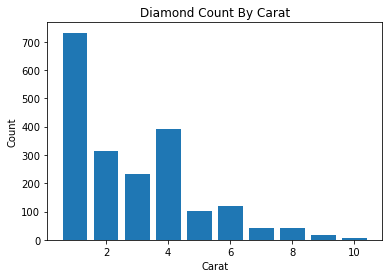

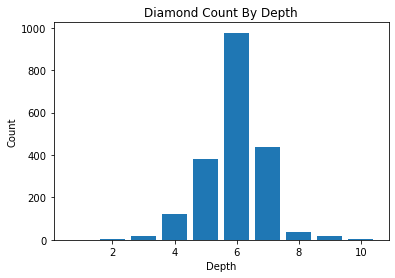

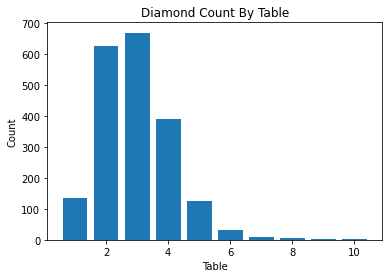

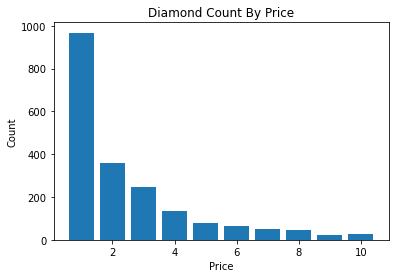

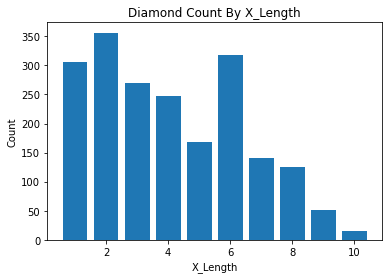

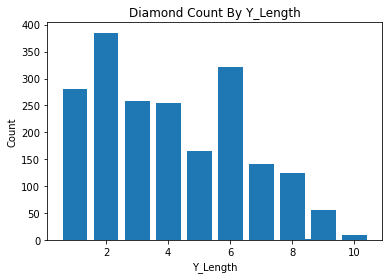

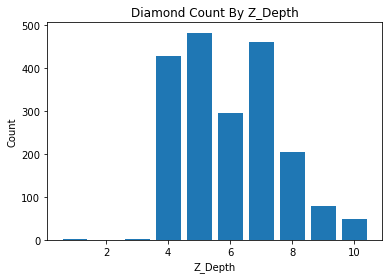

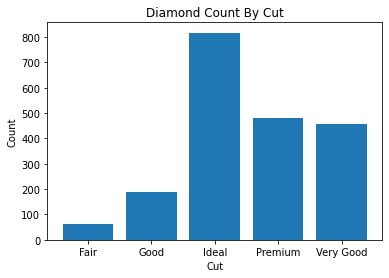

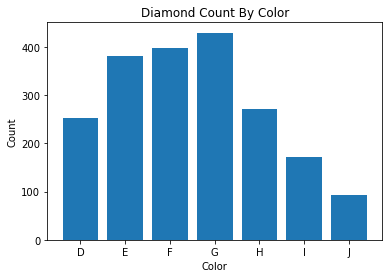

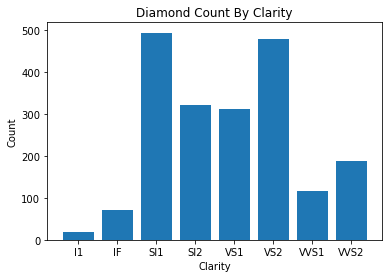

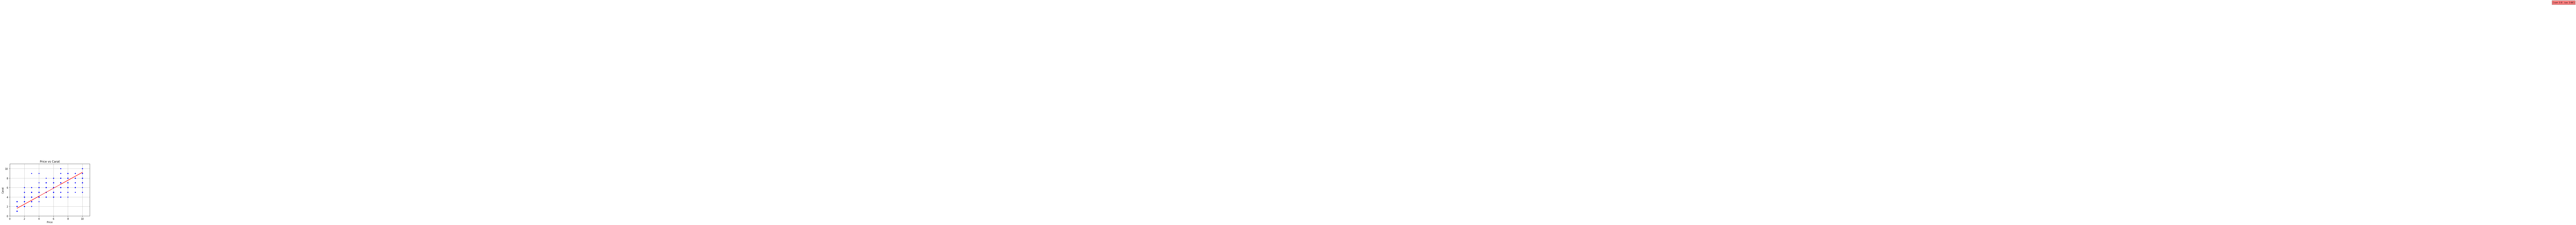

INSTANCES [3, 3, 7, 1, 62, 58, 3, 7.31, 7.37, 4.55]
INSTANCE CLASSIFICATION:  3
INSTANCE ACTUAL:  3
╒═════════════╤═══════════════════════════════════════════════════════╕
│             │ kNN: k=5 Nearest Neighbor Diamond Price Classifier    │
╞═════════════╪═══════════════════════════════════════════════════════╡
│ instance 0: │ [3, 5, 1, 3, '59.8', '61', 6, '7.87', '7.91', '4.72'] │
├─────────────┼───────────────────────────────────────────────────────┤
│ class 0:    │ 4                                                     │
├─────────────┼───────────────────────────────────────────────────────┤
│ actual 0:   │ 3                                                     │
╘═════════════╧═══════════════════════════════════════════════════════╛
╒═════════════╤═══════════════════════════════════════════════════════╕
│ instance 1: │ [2, 3, 6, 2, '63.1', '58', 1, '5.76', '5.72', '3.62'] │
├─────────────┼───────────────────────────────────────────────────────┤
│ class 1:    │ 1                   

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/6_/k75qjh1j6jv78p9zwdlp7r780000gn/T/tmp1bpzp0he/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.3978956, step = 0
INFO:tensorflow:global_step/sec: 362.731
INFO:tensorflow:loss = 1.271699, step = 100 (0.276 sec)
INFO:tensorflow:global_step/sec: 445.428
INFO:tensorflow:loss = 1.3101909, step = 200 (0.224 sec)
INFO:tensorflow:global_step/sec: 371.286
INFO:tensorflow:loss = 1.2226049, step = 300 (0.269 sec)
INFO:tensorflow:global_step/sec: 421.288
INFO:tensorflow:loss = 0.98641473, step = 400 (0.237 sec)
INFO:tensorflow:global_step/sec: 420.555
INFO:tensorflow:loss = 0.97136205, step = 500 (0.238 

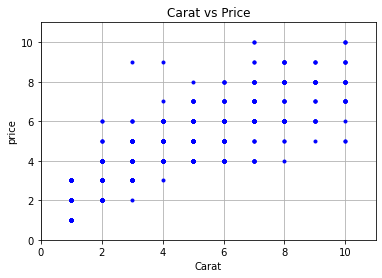

In [40]:

def main():
    execute_all_steps()
    print("ALL COMPUTATIONS COMPLETE")

if __name__ == "__main__":
    main()